#### Welcome to the Parallel C OpenMP hand-on session. 

#### In this Jupyter Notebook, you are provided with four scientific programming tasks that can be accelerated by OpenMP multithreading. Each examples has its own theme in loop-parallelisation and emphasises different strategies.

#### Before we start, install the following package for data-processing. 

In [ ]:
# For processing output data 
!pip install pandas

# Exercise 1. (Independent Loop Iterations) Monte-Carlo $\pi$

Given a unit circle enclosed by a unit square, assum $N$ sampling points are generated within the unit square, then the $h$ number of points landing on the circle can result in approximations of value $\pi$:
\begin{align*}
\pi \approx \frac{4h}{N}.
\end{align*}

Clearly, more sampling points produces better approximation. Since each sampling test is independent, makes the Monte-Carlo type of method a standard candidate to demonstrate multitheading parallelisation by OpenMP.



Note that in the python-based Jupyter environment you are working on, we need to prepend lines of code with `!` to indicate we wish to execute a shell command.

In [ ]:
# Compilee the serial code
!gcc -g -Wall -O3 -lm -o monte-carlo-pi-serial monte-carlo-pi-serial.c 

In [ ]:
%%time
#Execute the serial code
!./monte-carlo-pi-serial

### TODO: 
Add the worksharing-loop in monte-carlop-pi-openmp.c. 

In [ ]:
# Compile the openmp code
!gcc -fopenmp -g -Wall -O3 -lm -o monte-carlo-pi-openmp monte-carlo-pi-openmp.c 

In [ ]:
%%time

# Execute the openmp code, compare the time consumption with the serial version
!OMP_NUM_THREADS=4 ./monte-carlo-pi-openmp

# Exercise #2 (Dynamic Loop Iterations) Mandelbrot Set

The Mandelbrot set is a set of complex numbers $c$ for which the function $f_c(z_{i+1} ) = z_i^2 + c$  does not diverge to infinity when iterated from $z_0 = 0$.

Denote the Mandelbrot set by $M$, it can be written as

  $$ M := \{ c \in \mathbb{C} \big\rvert  z_{i+1} = z_{i}^2 +c <\infty, z_0 =0,\quad i=0, 1,\cdots, N \}$$  

### Convergence Test
Heuristically, the search region of $M$ can be shown to be narrowed into $[-2, 0.47] \times [-1.12, 1.12]i$. Therefore, a uniform mesh is laid over this region to search mandelbrot points.

For each point in the search region, it is tested with 100 iterations of $f_c(z_{i+1})\; i=0,\cdots, 100$. It is also shown that if the values is greater than $4$ than the point is guaranteed to diverge. 

### Dynamic workload
There is no a-priori knowledge of whether a point converges or diverges, as such the loop iteration searching through each point is dynamic: some point may diverge after a few iterations whereas others may exhaust entire 100 iteration, causes a load-balance issue for multi-threads.

Test performance with OpenMP Dynmic Scheduling!
 

Part 1. Compile and run the serial version of mandelbrot set generator.

In [2]:
# Compile the serial code

!gcc -Wall -O3 mandelbrot-serial.c -o mandelbrot-serial

In [3]:
# Execute the serial program 
!./mandelbrot-serial

Resolution #0, Points 100 by 100 
Resolution #1, Points 1000 by 1000 
Resolution #2, Points 10000 by 10000 


time in loading  0.027726173400878906
time in plotting  0.10677361488342285


<Figure size 864x864 with 0 Axes>

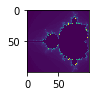

time in loading  0.18534445762634277
time in plotting  0.10637855529785156


<Figure size 864x864 with 0 Axes>

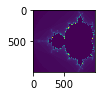

In [4]:
# Plot mandelbrot set to verify outputs
%run  'Mandelbrot-plot.py'

### TODO 
Add work-sharing loop constract and appropriate clauses in mandelbrot-omp-FIXME.c. Make sure that writing into the output file is ordered. 

In [ ]:
# Compile the openmp code
!gcc -fopenmp -g -Wall -O3 -o mandelbrot-omp mandelbrot-omp.c 

In [ ]:
%%time
# Execute the openmp code

!OMP_NUM_THREADS=4  ./mandelbrot-omp

In [ ]:
#  Verify the results by plot
%run  'Mandelbrot-plot.py'

You have probably found out that the OpenMP code does not improve the performance as expected. Inspect the source code, note that the loop iteration has to be ordered to avoid undefined output behaviour. 

### TODO 
Modify mandelbrot-split.c to separate the I/O from the calculation routine. 

In [ ]:
# compile the openmp code after IO separation
!gcc -fopenmp -g -Wall -O3 -o mandelbrot-split mandelbrot-split.c 


In [ ]:
%%time
 
!OMP_NUM_THREADS=4  ./mandelbrot-split

In [ ]:
# Verify the output again by plot
%run  'Mandelbrot-plot.py'

# Exercise #3 (Loop Dependence). Solve Linear Euqations by Conjugate Gradient Method 

The Conjugate Gradient method is a numerical method that is wildely used in solving certain type of matrix problems. It is also the base ingredient of [HPCG Benchmark](https://www.hpcg-benchmark.org/) for ranking HPC systems.


Consider solving a linear equation
\begin{align*}
Ax = b
\end{align*}
where matrix $A \in \mathbf{R}^{n\times n}$ is symmetric positive definite. 

The initial guess $x_0$ can be any approximation, we choose $0$. The baseline algorithm is statedd as following:

Compute $r_0 = b - Ax_0$

For $i= 0, \cdots, n$ Do 

 $\alpha_i := (r_i, r_i)/(Ap_i, p_i)$\;
 
 $x_{i+1}:=x_i+\alpha_i p_i$\;

 $r_{i+1}:=r_i -\alpha_i Ap_i$\;
 
 If $r_{i+1} <\text{tolerance}$ Then Break
 
 $\beta_i:= (r_{i+1}, r_{i+1}) / (r_i, r_i)$\;
 
 $p_{i+1}:= r_{i+1} +\beta_i p_i$

Conjugate Gradient method is a direct method that produces the exact solution at most $n$ steps, however, in practice a tolerance is usually set to terminate iterations.

CG method guarantees convergence for symmetric positive definite matrices in theory.



### Parallelisation in CG method
Note that the for-loop in CG method possesses the dependence between iterations. With multiple threads, the iteration needs to execute only after the dependence is met leading to a non-parallelizable loop. 

That being said, we can still use OpenMP to parallelise part of the code after analysing the bottleneck of its performance!

### Test Matrices
For numerical experiments, we will test two matrices [Trefethen_20](https://www.cise.ufl.edu/research/sparse/matrices/JGD_Trefethen/Trefethen_20.html) and [Msc04515](https://www.cise.ufl.edu/research/sparse/matrices/Boeing/msc04515.html).

Trefethen_20 is a small-sized problem in which you should see a fast convergence.

Msc04515 is a real-life problem arising from a structural engineering. It is a ill-conditioned matrix, which essentially means hard to solve and requires a lot more iterations for CG method if it converges at all.

In [ ]:
# Compile the serial code

!gcc -g -Wall -O3 -lm -o cg-std cg-std.c 

In [ ]:
# Execute the serial program to solve Trefethen_20 problem
!./cg-std 1e-5 < Trefethen_20.dat

### TODO
Add appropriate work-sharing loop construct and clauses in cg-std-omp.c

In [ ]:
# Compile the openmp code
!gcc -fopenmp -g -Wall -O3 -lm -o cg-std-omp cg-std-omp.c 

In [ ]:
%%time
# Verify the numerical result with the serial version
!OMP_NUM_THREADS=4  ./cg-std-omp 1e-5 < Trefethen_20.dat

In [ ]:
%%time
# Excute the parallel code to solve Boeing msc04515 problem. You may also want to attempt this problem with the serial code

!OMP_NUM_THREADS=4 ./cg-std-omp 1e-5 < msc04515.dat

# Exercise #4 (Parallelisaton vs. Convergence Rate): Solve Finite Difference Discretised Poisson Equation by Jacobi and Gauss-Seidel Methods


### Model Problem
Consider a 2D Poisson equation with Dirichlet boundary condition over a unit square domain $\Omega = [0,1] \times [0,1]$

\begin{align*}
-\Delta u &= f \; \text{in} \; \Omega \\
 u &= g \; \text{on} \; \partial \Omega
\end{align*}

Define a uniform partition of the domain $\Omega$ with nodal points at which the solution of the Poisson equation is sampled. Let $h$ be the uniform distance between two nodal points then the nodal points that lie on the mesh are defined by

\begin{align*}
x_i = i h, \; y_j = j h\qquad i,j = 0,\cdots, N
\end{align*}
where $N$ is a given mesh size and $i, j$ are integers along $x, y$-axis telling the location of each nodal point.  


### Discretisation
We use the second-order central finite difference method to discretise the Laplace operator
 \begin{align*}
     \big(\Delta u)\big)_{i,j} & = \big(D_{xx}^2u\big)_{i,j}+ \big(D_{yy}^2 u\big)_{i,j}\\[2ex]
     & \approx \frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{h^2} + \frac{u_{i,j+1}-2u_{i,j}+u_{i,j-1}}{h^2} 
 \end{align*}

leading to
\begin{align}
    -\big(\Delta u)\big)_{i,j} = \frac{4u_{i,j}-u_{i+1,j}-u_{i-1,j}-u_{i,j+1}-u_{i,j-1}}{h^2}=f(u_{i,j}).
\end{align}

The above finite-difference formula can further be represented by a five-point stencil matrix built in the mesh
\begin{align*}S = 
    \begin{pmatrix}
    & -1 & \\
    -1 & 4 &-1\\
    & -1 &
    \end{pmatrix}.
\end{align*}

Impose the Dirichlet boundary condition, on the interior nodal points the discretisation can be written as a linear equation

\begin{align*}
A u = f, \qquad A=\frac{1}{h^2}
    \begin{pmatrix}
S & I \\
I & S & I \\
& I & \ddots & \ddots \\
& & \ddots & \ddots & I \\
& & & I & S
\end{pmatrix}
\end{align*}
where $A \in \mathbb{R}^{(N-2)^2 \times (N-2)^2}$, $u \in \mathbb{R}^{(N-2)^2}$ and $f \in \mathbb{R}^{(N-2)^2}$.

Note that with the five-point stencil, the matrix $A$ was never assembled and is nowhere in sight! 


### Numerical Solvers

To solve the linear system, two iterative methods are used and compared. 

$\textbf{Jacobi method}$

\begin{align*}
u^{(k+1)} = D^{-1}( f - Lu_{k} -Uu_k),
\end{align*}
where $D, L, U$ are the diagonal matrix, lower triangular matrix and upper triangular matrix of $A$, respectively.
Write into stecil,
\begin{align*}
u^{(k+1)}_{ij} = (h^2 f_{ij} + u^{(k)}_{i-1,j} +u^{(k)}_{i+1,j} + u^{(k)}_{i, j-1}+u^{(k)}_{i,j+1})/4 \qquad i,j = 1,\cdots, N-1 
\end{align*} 



$\textbf{Gauss-Seidel method}$ follows a similar scheme:

\begin{align*}
u^{(k+1)} = D^{-1} (f - L u_{k+1}- U u_k),
\end{align*}

Note that Gauss-Seidel method uses the most recent estimate to update.
 
Likewise, applying the Gauss-Seidel method doesn't require assembling $D, L, U$ matrices for finite-difference discretised Laplacian. 
Elementwise, we have 
\begin{align*}
u^{(k+1)}_{ij} = (h^2 f_{ij} + u^{(k)}_{i-1,j} +u^{(k+1)}_{i+1,j} + u^{(k+1)}_{i, j-1}+u^{(k)}_{i,j+1})/4 \qquad i,j = 1,\cdots, N-1 
\end{align*}

### Convergence Rate

Gauss Seidel method is known to be faster than Jacobi method (twice faster as stated in some textbooks), both of their convergence rate for our application is governed by the following theorem.

$\textbf{Theorem}\;$
The convergence rate of Jacobi and Gauss-Seidel method for the 5-point stencil finite difference method of the Poisson equation on a uniform mesh with size $h$ is
\begin{align*}
1- \mathcal{O}(h^2)
\end{align*}

As such, the convergence rate stalls as the mesh gets finer. To alleviate the shortcoming of the numerical method, let's try improving the perforance by OpenMP! 

In [ ]:
# Compile the serial code
!gcc -g -Wall -O3 -lm -o fd_laplace-serial fd_laplace-serial.c 

In [ ]:
# Execute the serial code with Jacobi method to solve on a grid of 300 x 300 meshes i.e. matrix size 90000 x 90000 at stopping criterion 1e-5.
!./fd_laplace-serial 300 1e-5 Jacobi

In [ ]:
#  Verify the results by plot
%run  'Laplace-plot.py'

In [ ]:
# Compile the parallel code

!gcc -fopenmp -g -Wall -O3 -lm -o fd_laplace-omp fd_laplace-omp.c 

In [ ]:
# Execute the parallel code with Jacobi method to solve on a grid of 300 x 300 meshes i.e. matrix size 90000 x 90000 at stopping criterion 1e-5.

!OMP_NUM_THREADS=4 ./fd_laplace-omp 300 1e-5 Jacobi

In [ ]:
#  Verify the results by plot
%run  'Laplace-plot.py'

In [ ]:
# Execute the parallel code with Gauss-Seidel method to solve on a grid of 300 x 300 meshes i.e. matrix size 90000 x 90000 at stopping criterion 1e-5.

!OMP_NUM_THREADS=4 ./fd_laplace-omp 300 1e-5 Gauss-Seidel

In [ ]:
#  Verify the results by plot
%run  'Laplace-plot.py'